# A Brief Intro to VIME
## Why do we need VIME?
Variational Information Maximizing Exploration (VIME) aims to help an agent explore its environment better, especially when **rewards are sparse or hard to find**. In typical reinforcement learning, agents rely on rewards to learn what actions are valuable. However, in environments where rewards are rare or delayed, agents can struggle to learn effectively because they don’t receive enough feedback.

## How does it work?

VIME solves this by giving the agent “intrinsic rewards,” which encourage it to seek out new or unknown areas in the environment, even without an immediate reward. These intrinsic rewards come from an **information gain**: every time the agent encounters a new or surprising situation, it updates its understanding of how the environment works, and VIME rewards it for that learning.

Mathematically, information gain for a state transition is defined as the change in the agent's **posterior belief** about the environment dynamics given new data. This is expressed as:

$$
\text{Information Gain} = D_{\text{KL}}\left( p(\theta | \tau, a) \; || \; p(\theta | \tau) \right)
$$

where:
- $ D_{\text{KL}} $ is the **Kullback-Leibler (KL) divergence**,
- $ p(\theta | \tau) $ is the agent's prior belief about the environment dynamics (parameterized by $\theta$),
- $ p(\theta | \tau, a) $ is the posterior belief after observing a new action $ a $ and state transition $\tau$.

In simple terms, the KL divergence here measures how different the updated belief is from the prior belief. The more the belief changes, the more the agent has learned, which translates to higher information gain.

### Step-by-Step Process

1. **Dynamics Model**: VIME uses a Bayesian model to represent the environment dynamics, which estimates the probability $ p(s' | s, a, \theta) $ of reaching a new state $ s' $ given the current state $ s $, action $ a $, and parameters $ \theta $.

2. **Posterior Update**: Every time the agent takes an action and observes a transition, it updates its model of the environment dynamics. This update changes the posterior distribution $ p(\theta | \tau, a) $, where $ \tau $ represents the transition data collected so far.

3. **Intrinsic Reward Calculation**: The intrinsic reward $ r_{\text{int}} $ is then calculated as the KL divergence between the updated posterior and the prior:

   $$
   r_{\text{int}} = D_{\text{KL}}\left( p(\theta | \tau, a) \; || \; p(\theta | \tau) \right)
   $$

   This intrinsic reward encourages the agent to explore areas where its model has the most to learn.

4. **Total Reward**: The agent’s objective becomes maximizing the sum of both **extrinsic rewards** (from the environment) and **intrinsic rewards**:

   $$
   R_{\text{total}} = R_{\text{extrinsic}} + \lambda \cdot R_{\text{int}}
   $$

   Here, $ \lambda $ is a scaling factor that balances exploration (intrinsic rewards) and exploitation (extrinsic rewards).

### Why would VIME Work?

By maximizing information gain, VIME effectively motivates the agent to explore unfamiliar states that will help it learn more about the environment. This approach is particularly helpful in sparse reward settings because the agent doesn’t rely solely on external rewards but is guided by curiosity.


***

In the following notebook, we will augment the DQN algorithom that we implemented in hw1 with VIME. Note that to obtain a policy with better performance we shall train for more episodes, but for demoing we just use 500 eps.

## 1. Environment setup
You are also encouraged to try out other environments with sparse rewards.

In [ ]:
%load_ext autoreload
%autoreload 2

import gym
import torch
import numpy as np
from loguru import logger
from torch.optim import Adam
import matplotlib.pyplot as plt
from IPython.display import Image

from src.utils import (
    device,
    set_seed,
    eval_policy,
    demo_policy,
    plot_returns,
    plot_returns_compare,
    save_frames_as_gif
)

plt.ion()


SEED: int = 42
ENVIRONMENT_NAME: str='MountainCar-v0'

# torch related defaults
DEVICE = device()
torch.set_default_dtype(torch.float32)
print(f"Using device: {DEVICE}")

# Use random seeds for reproducibility
set_seed(SEED)

# instantiate the environment
environment = gym.make(ENVIRONMENT_NAME)

# get the state and action dimensions
num_actions = environment.action_space.n
state_dimension = environment.observation_space.shape[0]

2024-10-30 02:38:51.017 | INFO     | src.utils:device:51 - Using cuda device.
2024-10-30 02:38:51.018 | INFO     | src.utils:set_seed:37 - Random seed set as 42.


Using device: cuda


***

## Experience Replay Buffer/Memory

In [2]:
from src.buffer import ReplayBuffer
################################## Hyper-parameters Tuning ##################################

BATCH_SIZE: int = 64
#############################################################################################

# instantiate the memory replay buffer
memory = ReplayBuffer(
    capacity=10_000, batch_size=BATCH_SIZE
)

***

## 2. DQN (Deep Q-learning + experience replay + target network)

In [ ]:
from src.networks import ValueFunctionQ
from src.dqn import train_one_epoch as dqn_epoch
from src import dqn
################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 500
HIDDEN_DIMENSION: int = 64
LEARNING_RATE: float = 2e-3
WITH_VIME = False

#############################################################################################
dqn.eps = 2.0
dqn.EPS_DECAY = 0.999_95
dqn.EPS_END = 0.1
# instantiate the state-action value function, Q
Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION, with_vime=WITH_VIME
).to(DEVICE)
# initialize the target network
target_Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION, with_vime=WITH_VIME
).to(DEVICE)

# Learn the policy
optimizer = Adam(Q.parameters(), LEARNING_RATE)

memory.clear()
mean_returns, std_returns = [], []
for epoch in range(EPOCHS):
    
    # copy target network params
    target_Q.load_state_dict(Q.state_dict())

    dqn_epoch(
        env=environment, Q=Q, target_Q=target_Q,
        memory=memory, optimizer=optimizer, with_vime=WITH_VIME
    )
    
    episode_return_mean, episode_return_std = eval_policy(Q, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)

    from src.dqn import eps
    
    logger.info(f'Epoch: {epoch:3d}, \t return: {episode_return_mean:.2f}, \t eps: {eps:.2f}')

    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name='dqn', dynamic=True
        )

<Figure size 640x480 with 0 Axes>

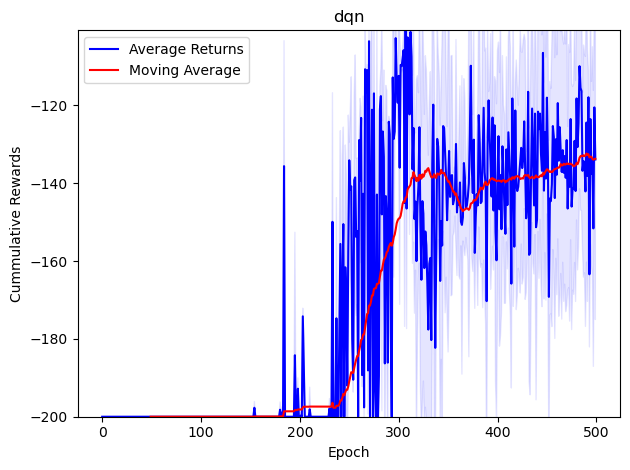

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
plot_returns(
    mean_returns, std_returns, method_name='dqn'
)

MovieWriter imagemagick unavailable; using Pillow instead.


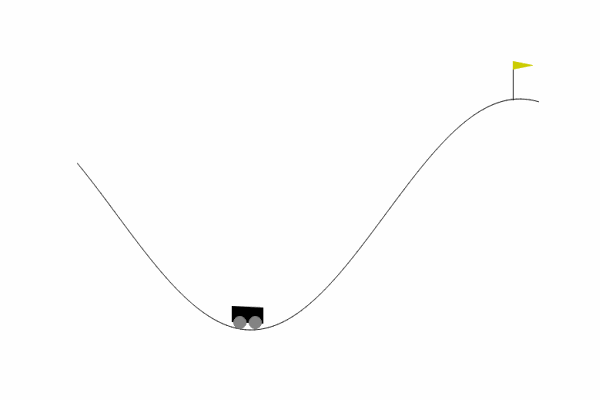

In [9]:
frames = demo_policy(
    Q, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name='dqn')
Image(open(gif_path,'rb').read())

***

## 3. DQN with VIME

In [5]:
from src.networks import ValueFunctionQ
from src.dqn import train_one_epoch as dqn_epoch
from src import dqn
################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 500
HIDDEN_DIMENSION: int = 64
LEARNING_RATE: float = 2e-3
BETA = 10

#############################################################################################
dqn.eps = 2.0
dqn.EPS_DECAY = 0.999_95
dqn.EPS_END = 0.1
WITH_VIME = True
# instantiate the state-action value function, Q_VIME
Q_VIME = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION, with_vime=WITH_VIME
).to(DEVICE)
# initialize the target network
target_Q_VIME = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION, with_vime=WITH_VIME
).to(DEVICE)

# Learn the policy
optimizer_vime = Adam(Q_VIME.parameters(), LEARNING_RATE)

memory.clear()
mean_returns_vime, std_returns_vime = [], []
for epoch in range(EPOCHS):
    
    # copy target network params
    target_Q_VIME.load_state_dict(Q_VIME.state_dict())

    dqn_epoch(
        env=environment, Q=Q_VIME, target_Q=target_Q_VIME,
        memory=memory, optimizer=optimizer_vime, with_vime=WITH_VIME
    )
    
    episode_return_mean, episode_return_std = eval_policy(Q_VIME, ENVIRONMENT_NAME)
    mean_returns_vime.append(episode_return_mean)
    std_returns_vime.append(episode_return_std)

    from src.dqn import eps
    
    logger.info(f'Epoch: {epoch:3d}, \t return: {episode_return_mean:.2f}, \t eps: {eps:.2f}')

    if epoch:
        plot_returns(
            mean_returns_vime, std_returns_vime, method_name='dqn_vime', dynamic=True
        )

<Figure size 640x480 with 0 Axes>

MovieWriter imagemagick unavailable; using Pillow instead.


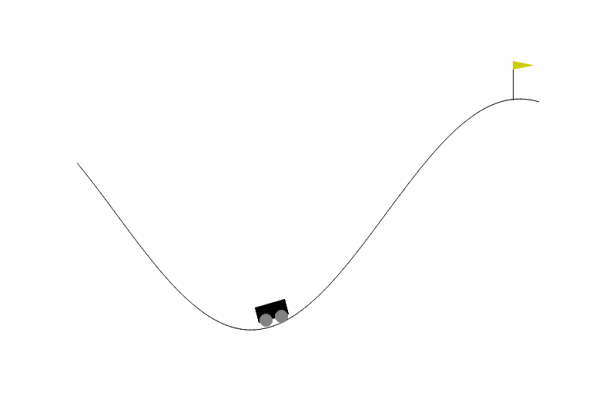

In [6]:
frames = demo_policy(
    Q_VIME, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name='dqn_vime')
Image(open(gif_path,'rb').read())

***

From the demo gifs we could see DQN augmented with VIME was able to reach the mountain peak while the one without VIME failed. We can further plot the two reward curves together and examine the difference. As shown in the plot, VIME leads to a performance gain over heuristic exploration.

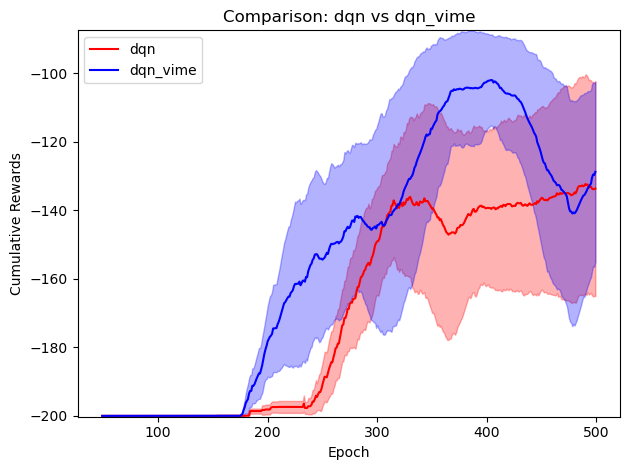

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_returns_compare(mean_returns, std_returns, 'dqn', mean_returns_vime, std_returns_vime, 'dqn_vime')  # Compare DQN and DQN with VIME